In [69]:
import cv2
import numpy as np

import IPython.display
import ipywidgets as widgets  # Using the ipython notebook widgets


#Use 'jpeg' instead of 'png' (~5 times faster)
import PIL.Image
from io import BytesIO

#Use 'jpeg' instead of 'png' (~5 times faster)
def imdisplay(img, fmt='jpeg',width=500):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_p = PIL.Image.fromarray(img)    
    f = BytesIO()
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    new_p.save(f, fmt)
    return IPython.display.Image(data=f.getvalue(), width=width)


from IPython.display import Javascript
def preventScrolling():
    disable_js = """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
    display(Javascript(disable_js))

    
import urllib
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

# This function tries to find the 5-target pattern that looks like this
#  0  1  2
#  3     4
# The input is a list of (x,y) locations of possible targets, where each location is
# a numpy array of length 2. The output is a list of 5 targets in the proper order.
# If 5 targets in the correct configuration is not found, it returns an empty list.
def order_targets(allTargets):
    orderedTargets = []
    nTargets = len(allTargets)
    if nTargets < 5:
        return orderedTargets

    # Find 3 targets that are in a line.
    dMin = 1e9  # distance from a point to the midpt between points 1,3
    d02 = 0     # distance between points 1,3
    for i in range(0, nTargets):
        for j in range(i+1, nTargets):
            # Get the mid point between i,j.
            midPt = (allTargets[i] + allTargets[j])/2

            # Find another target that is closest to this midpoint.
            for k in range(0, nTargets):
                if k==i or k==j:
                    continue
                d = np.linalg.norm(allTargets[k] - midPt)   # distance from midpoint
                if d < dMin:
                    dMin = d        # This is the minimum found so far; save it
                    i0 = i
                    i1 = k
                    i2 = j
                    d02 = np.linalg.norm(allTargets[i0] - allTargets[i2])

    # If the best distance from the midpoint is < 30% of the distance between
	# the two other points, then we probably have a colinear set; otherwise not.
    if dMin / d02 > 0.3:
        return orderedTargets   # return an empty list

    # We have found 3 colinear targets:  p0 -- p1 -- p2.
    # Now find the one closest to p0; call it p3.
    i3 = findClosest(allTargets, i0, excluded=[i0,i1,i2])
    if i3 is None:
        return []   #  return an empty list

    # Now find the one closest to p2; call it p4.
    i4 = findClosest(allTargets, i2, excluded=[i0,i1,i2,i3])
    if i4 is None:
        return []   #  return an empty list

    # Now, check to see where p4 is with respect to p0,p1,p2.  If the
    # signed area of the triangle p0-p2-p3 is negative, then we have
    # the correct order; ie
    #   0   1   2
    #   3		4
    # Otherwise we need to switch the order; ie
    #   2	1	0
    #   4		3

    # Signed area is the determinant of the 2x2 matrix [ p3-p0, p2-p0 ].
    p30 = allTargets[i3] - allTargets[i0]
    p20 = allTargets[i2] - allTargets[i0]
    M = np.array([[p30[0], p20[0]], [p30[1], p20[1]]])
    det = np.linalg.det(M)

    # Put the targets into the output list.
    if det < 0:
        orderedTargets.append(allTargets[i0])
        orderedTargets.append(allTargets[i1])
        orderedTargets.append(allTargets[i2])
        orderedTargets.append(allTargets[i3])
        orderedTargets.append(allTargets[i4])
    else:
        orderedTargets.append(allTargets[i2])
        orderedTargets.append(allTargets[i1])
        orderedTargets.append(allTargets[i0])
        orderedTargets.append(allTargets[i4])
        orderedTargets.append(allTargets[i3])

    return orderedTargets


# In the list of points "allPoints", find the closest point to point i0, that is not
# one of the points in the excluded list.  If none found, return None.
def findClosest(allPoints, i0, excluded):
    dMin = 1e9
    iClosest = None
    for i in range(0, len(allPoints)):
        if i in excluded:
            continue
        d = np.linalg.norm(allPoints[i] - allPoints[i0])
        if d < dMin:
            dMin = d
            iClosest = i
    return iClosest

def drawPose(img, text, org=(50, 50)):
    # Printing options
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # fontScale 
    font_scale = 0.5
    # Blue color in BGR 
    font_color = (255, 0, 0)
    # White background
    bg_color = (255,255,255)
    # Line thickness of 2 px 
    thickness = 1
    ((txt_w, txt_h), _) = cv2.getTextSize(text, font, font_scale, thickness)
    # Place text background.
    back_tl = org[0], org[1] - int(1.3 * txt_h)
    back_br = org[0] + txt_w, org[1]
    cv2.rectangle(img, back_tl, back_br, bg_color, -1)
    # Show text.
    txt_tl = org[0], org[1] - int(0.3 * txt_h)
    return cv2.putText(img, text, txt_tl, 
                       fontFace=font, 
                       fontScale=font_scale, 
                       color=font_color, 
                       thickness=thickness, 
                       lineType=cv2.LINE_AA)

def drawCCCLabels(img, pts, org=(0, -10)):
    # Printing options
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
    # offset 
     
    # fontScale 
    font_scale = 0.5
    # Blue color in BGR 
    font_color = (0, 0, 255)
    # White background
    bg_color = (255,255,255)
    # Line thickness of 2 px 
    thickness = 2
    for i, point in enumerate(pts):
        img = cv2.putText(img, str(i), (int(point[0]+org[0]),int(point[1]+org[1])), 
                          fontFace=font, 
                          fontScale=font_scale, 
                          color=font_color, 
                          thickness=thickness, 
                          lineType=cv2.LINE_AA)
    return img

def nothing(x):pass    
    
def processFrame(original_img):
    
    image_height = original_img.shape[0] 
    image_width = original_img.shape[1]
    
    # Convert BGR to HSV.
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)# Split into the different bands.
    planes = cv2.split(hsv_img)
    
    # Create output thresholded image.
    thresh_img = np.full((image_height, image_width), 255, dtype=np.uint8)
    
    for i in range(3):      
        _,low_img = cv2.threshold(planes[i], low_thresholds[i], 255, cv2.THRESH_BINARY)            
        _,high_img = cv2.threshold(planes[i], high_thresholds[i], 255, cv2.THRESH_BINARY_INV)            
        thresh_band_img = cv2.bitwise_and(low_img, high_img)            
        thresh_img = cv2.bitwise_and(thresh_img, thresh_band_img)
    
    innerComponents, outerComponents = applyMorphology(thresh_img)
    return [thresh_img, innerComponents, outerComponents]

def applyMorphology(thresh_img):
    kernelClose = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    kernelOpen = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernelDilate = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
    kernelErode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    innerComponents = cv2.dilate(cv2.erode(~thresh_img, kernelErode),kernelDilate)

    filtered_img_close = cv2.morphologyEx(thresh_img, cv2.MORPH_CLOSE, kernelClose)
    filtered_img_open = cv2.morphologyEx(filtered_img_close, cv2.MORPH_OPEN, kernelOpen,10)
    outerComponents = filtered_img_open

    return [innerComponents, outerComponents]

def color_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img



def getIntrinsicCamMatrix(f, sx, sy, center=[0,0]):
    return np.array([[f/sx, 0, center[0]], [0, f/sy, center[1]], [0, 0, 1]])

# Returns Mext
def getExtrinsicCamMatrix(H_w_c):
    Mext = H_w_c[0:3, :]
    return Mext


<div id="assignment_show" class="assignment content_underline_links">

  <div class="description user_content student-version enhanced"><p>The task for today is to use OpenCV to detect a target composed of five contrasting concentric circles (CCCs) in an image, and compute the pose of the target. The dimensions (in inches) of the target pattern are shown in the figure.</p>
<p><img src="https://elearning.mines.edu/courses/25410/files/1886678/preview" alt="CCC Tags" width="311" height="214" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/1886678" data-api-returntype="File" style="max-width: 311px;"></p>
<p>The input image is “CCCtarget.jpg”, and is shown below. Assume that the camera that took this image has focal length equal to 531.0 pixels (in both x and y), image center at (x=320.0, y=240.0), and no lens distortion.</p>
<p><img src="https://elearning.mines.edu/courses/25410/files/2220603/download" alt="CCCtarget.jpg" style="max-width: 640px;"></p>
<h3>Finding correspondence</h3>
<p>In a previous homework, you used binary image operations to detect CCC targets in an image. Now, you must order the detected targets, meaning that you have to figure out which CCC is which, and put them into the correct order, namely</p>
<pre> 0 1 2<br> 3   4</pre>
<p>The Python function “orderTargets()” (<span class="instructure_file_holder link_holder"><a class="instructure_file_link" title="order_targets.py" href="https://elearning.mines.edu/courses/25410/files/2220631/download?wrap=1">order_targets.py</a></span>) performs this operation. It takes a list of target centroids and tries to determine the correct order. The strategy is to first find a collinear triple of targets, and assume that these are targets 0, 1, and 2. Then, it finds the closest remaining one to target 0, and assumes that this is target 3. Then, it finds the closest remaining one to target 2, and assumes that this is target 4. Finally, it checks to make sure that targets 3 and 4 are on the right hand side of the line going from 0 to 2; and if not it renumbers all the targets. If “orderTargets()” finds five targets in the correct configuration, it returns a list of five target centroids in the correct order. Otherwise, it returns an empty list.</p>
<h3>Finding pose</h3>
<p>The next step is to compute the pose of the target, using OpenCV’s “solvePnP()” function. You will need to pass in two sets of corresponding points:</p>
<ul>
<li>The five 3D points on the model, in a numpy array of size (5,3). Each row of the array is contains the X,Y,Z coordinates of the point (in inches).</li>
<li>The corresponding five 2D points in the image, in a numpy array of size (5,2). Each row of the array contains the x,y coordinates of the point (in pixels).</li>
</ul>
<p>If successful, the function will return the pose as a rotation vector and translation vector. </p>
<h3>To do</h3>
<ul>
<li>Read in the input image.</li>
<li>Detect CCC targets, using your methods from HW2.</li>
<li>Call “orderTargets()” to find a set of five CCCs in the correct order.</li>
<li>Draw the correct label number (i.e., 0,1,2,3,4) on each CCC target in the image.</li>
<li>Compute the pose by calling OpenCV’s “solvePnP()” function.</li>
<li>Draw the coordinate axes on the image, by calling OpenCV’s “projectPoints()”.</li>
<li>Finally, write the pose onto the image using OpenCV’s “putText()” function.</li>
</ul>
<p>When writing the pose onto the image, don’t write the numbers with too many digits, as it will clutter up the image. For translation, just use one significant digit to the right of the decimal point. For the rotation vector, use two significant digits to the right of the decimal point.</p>
<h3>Turn in</h3>
<ul>
<li>The image with CCC targets labeled, coordinate axes drawn, and the pose written onto the image.</li>
<li>Your Python program.</li>
</ul>
<p>Hint: The correct pose for this image is somewhere in the following ranges.</p>
<ul>
<li>For translation, X is between 5 and 10, Y is between -20 to -5, and Z is between 70 to 80.</li>
<li>For the rotation vector, the X component is between -0.4 to -0.1, the Y component is between 0 and 0.05, and the Z component is between -0.9 and -0.7.</li>
</ul></div>


  <div style="display: none;">
    <span class="timestamp">1602309599</span>
    <span class="due_date_string">10/09/2020</span>
    <span class="due_time_string">11:59pm</span>
  </div>
</div>

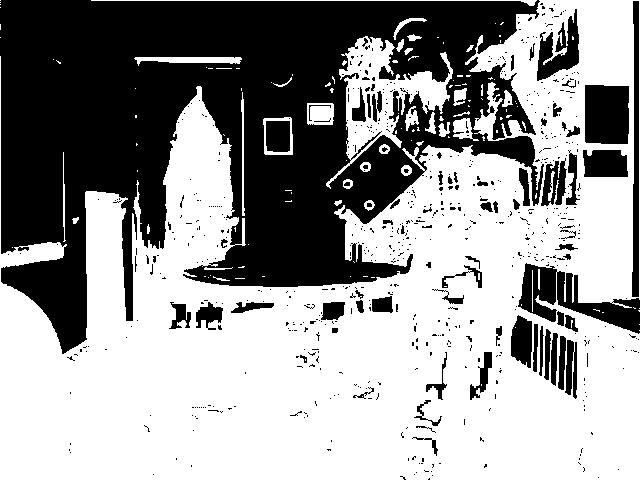

In [70]:
d1 = IPython.display.display("", display_id=1)

low_thresholds = [0, 0, 0]
high_thresholds = [255, 255, 150]

focal_length = 531.0
x_center = 320.0
y_center = 240.0

CCCs_height = 4.55
CCCs_width = 7.4

P_M = np.array([[-CCCs_width / 2, -CCCs_height / 2, 0.0],
                    [0.0, -CCCs_height / 2, 0.0],
                    [CCCs_width / 2, -CCCs_height / 2, 0.0],
                    [-CCCs_width/2, CCCs_height / 2.0, 0.0],
                    [CCCs_width / 2, CCCs_height / 2.0, 0.0]])


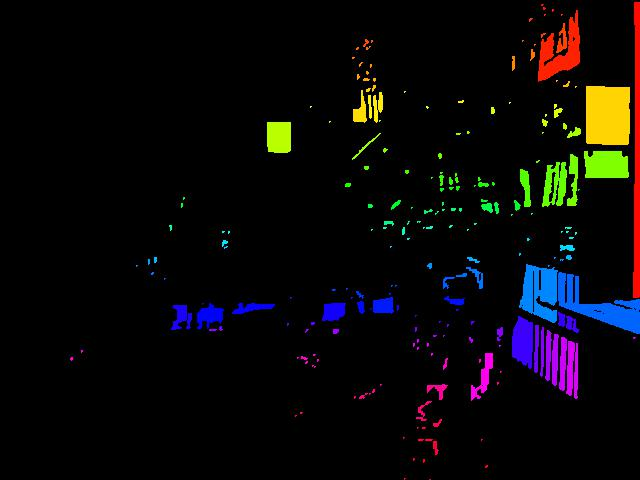

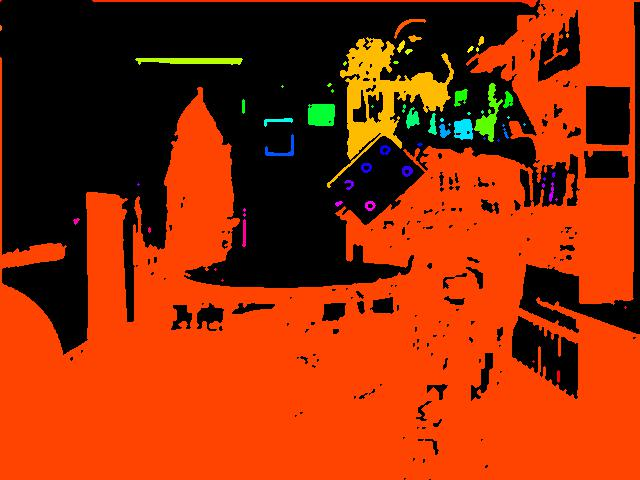

In [71]:
bgr_img = cv2.imread('CCCtarget.jpg')
thresh_img, innerComponents, outerComponents= processFrame(bgr_img)
d1.update(imdisplay(thresh_img))

d2 = IPython.display.display("", display_id=2)
d3 = IPython.display.display("", display_id=3)
num_labels_inner, labels_im_inner, innerStats, innerCentroids = cv2.connectedComponentsWithStats(innerComponents, connectivity=8)
color_labeled_img_inner = color_components(labels_im_inner)
d2.update(imdisplay(color_labeled_img_inner))

num_labels_outer, labels_im_outer, outerStats, outerCentroids = cv2.connectedComponentsWithStats(outerComponents, connectivity=8)
color_labeled_img_outer = color_components(labels_im_outer)
d3.update(imdisplay(color_labeled_img_outer))

 


In [72]:
pts = []
for i, i_centroid in enumerate(innerCentroids):
    if (i == 0):
        continue
    for j, o_centroid in enumerate(outerCentroids):
        if (j == 0):
            continue
        xi = int(i_centroid[0])
        yi = int(i_centroid[1])
        xo = int(o_centroid[0])
        yo = int(o_centroid[1])
        if(np.abs(xi - xo) < 3):
            if(np.abs(yi - yo) < 3):
                # Found a CCC
                pts.append([xi,yi])
                
print("CCC Coordinates:\n",pts)
pts = np.array(pts, np.float32)  
pts = order_targets(pts)
print("\n\nOrdered Coordinates", pts)
pts = np.array(pts, np.float32)  
K = getIntrinsicCamMatrix(focal_length, 1, 1, center=[x_center,y_center])
print("\n\nK",K)

CCC Coordinates:
 [[384, 149], [366, 167], [406, 171], [347, 184], [369, 205]]


Ordered Coordinates [array([347., 184.], dtype=float32), array([366., 167.], dtype=float32), array([384., 149.], dtype=float32), array([369., 205.], dtype=float32), array([406., 171.], dtype=float32)]


K [[531.   0. 320.]
 [  0. 531. 240.]
 [  0.   0.   1.]]




Pose Found:  True


Rotation Vector:  [[ 0.35577566]
 [ 0.23451081]
 [-0.77635745]]


Translation Vector:  [[ 8.21048251]
 [-9.07834706]
 [77.29533145]]


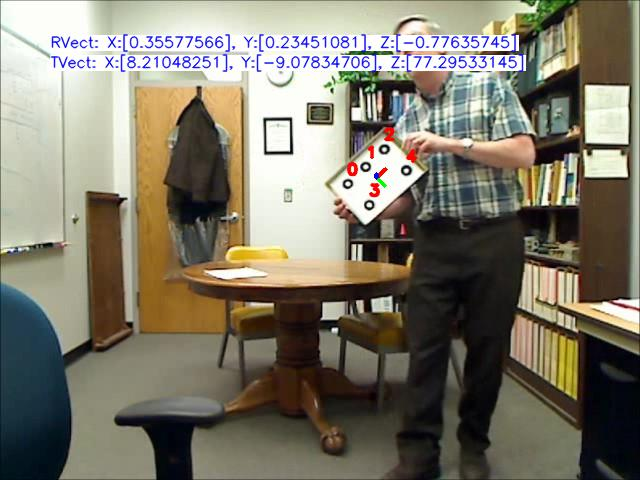

In [73]:
isPoseFound, rvec, tvec = cv2.solvePnP(objectPoints=P_M,  # Numpy array, size (5,3)
                                       imagePoints=pts,  # Numpy array, size (5,2)
                                       cameraMatrix=K, distCoeffs=None)

print("\n\nPose Found: ", isPoseFound)
print("\n\nRotation Vector: ", rvec)
print("\n\nTranslation Vector: ", tvec)

# Draw coordinate axes onto the image.  Scale the length of the axes    
# according to the size of the model, so that the axes are visible.
W = np.amax(P_M,axis=0) - np.amin(P_M,axis=0)  # Size of model in X,Y,Z
L = np.linalg.norm(W)   # Length of the diagonal of the bounding box
d = L/5 # This will be the length of the coordinate axes
pAxes = np.float32([[0, 0, 0],  # origin
                    [d, 0, 0],  # x axis
                    [0, d, 0],  # y axis
                    [0, 0, d]  # z axis
                   ])
d5 = IPython.display.display("", display_id=5)
pImg, J = cv2.projectPoints(objectPoints=pAxes,     # Numpy array, size (N,3)
                            rvec=rvec, tvec=tvec,cameraMatrix=K, distCoeffs=None)    

In [74]:
pImg = pImg.reshape(-1, 2)  # reshape from size (N,1,2) to (N,2)
poseR = f'''RVect: X:{rvec[0]}, Y:{rvec[1]}, Z:{rvec[2]}'''
poseT = f'''TVect: X:{tvec[0]}, Y:{tvec[1]}, Z:{tvec[2]}''';
# pose = f'''RVect: {rvec}, Tvect: {tvec} '''
cv2.line(bgr_img, tuple(np.int32(pImg[0])),tuple(np.int32(pImg[1])), (0, 0, 255), 3)  # x red
cv2.line(bgr_img, tuple(np.int32(pImg[0])),tuple(np.int32(pImg[2])), (0, 255, 0), 3)  # y green
cv2.line(bgr_img, tuple(np.int32(pImg[0])),tuple(np.int32(pImg[3])), (255, 0, 0), 3)  # z blue
drawCCCLabels(bgr_img, pts)
bgr_img = drawPose(bgr_img, poseR, (50,50))
bgr_img = drawPose(bgr_img, poseT, (50,70))
d5.update(imdisplay(bgr_img))
# cv2.imshow("Image", bgr_img)